# 環境構築

In [1]:
# インポート
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import japanize_matplotlib
import MeCab


In [2]:
# 空のDataFrameを初期化
combined_df = pd.DataFrame()

# CSVファイルを結合
for year in range(2011, 2014):
    file_name = f"data/r_{year}.csv"
    df_temp = pd.read_csv(
        file_name,
        header=None,
        names=['CD', 'DATE', 'TEXT']
    )
    # 'year'カラムを追加
    df_temp['year'] = year
    # 結合するDataFrameに追加
    combined_df = pd.concat([combined_df, df_temp], ignore_index=True)

combined_df


,CD,DATE,TEXT,year
0,2753,20110303,平成23年3月期決算短信〔日本基準〕（連結）平成23年4月4日（百万円未満切捨て）上場会社名...,2011
1,6305,20110304,（百万円未満切捨て）１．平成23年３月期の連結業績（平成22年４月１日～平成23年３月31日...,2011
2,2753,20120303,平成24年3月期第1四半期決算短信〔日本基準〕（連結）平成23年7月4日（百万円未満切捨て）...,2012
3,6305,20120304,（百万円未満四捨五入）１．平成24年３月期の連結業績（平成23年４月１日～平成24年３月31...,2012
4,2753,20130303,平成25年3月期決算短信〔日本基準〕（連結）平成25年4月1日（百万円未満切捨て）上場会社名...,2013
5,6305,20130304,（百万円未満四捨五入）１．平成25年３月期の連結業績（平成24年４月１日～平成25年３月31...,2013


## やるべきこと
- 縦軸は企業数
- 品詞出現回数
  - 名詞の出現回数
  - 動詞の出現回数
  - 形容詞の出現回数
  - ->品詞ごとの単語出現回数を計測
- 単語出現回数
  - ある年のある銘柄について具体例を挙げる
  - 頻出単語をstopwordsにする
- N-gram出現回数
  - uni-gram
  - bi-gram
  - tri-gram
  - 数字や記号をstopwordsにする
  - あまり効果がない
- ROA別分析
  - 2年後のROAが上昇している3銘柄の決算短信頻出単語
  - 2年後のROAが下降している3銘柄の決算短信頻出単語
  - ROAが高い/低い業界があるため特徴量に入れるべきことを示唆
  - 

In [3]:
# 文字化けを検知
def check_encoding(text):
    try:
        text.encode('utf-8').decode('utf-8')
        return True
    except UnicodeDecodeError:
        return False

combined_df['TEXT'] = combined_df['TEXT'].astype(str)

# 文字化けしている可能性があるエントリの割合を計算
corrupted_percentage = combined_df['TEXT'].apply(lambda x: not check_encoding(x)).mean() * 100

corrupted_percentage


0.0

In [4]:
# 文字化けを解消

combined_df['TEXT'] = combined_df['TEXT'].apply(lambda x: x.encode('sjis', errors='ignore').decode('sjis'))

combined_df


,CD,DATE,TEXT,year
0,2753,20110303,平成23年3月期決算短信〔日本基準〕（連結）平成23年4月4日（百万円未満切捨て）上場会社名...,2011
1,6305,20110304,（百万円未満切捨て）１．平成23年３月期の連結業績（平成22年４月１日平成23年３月31日）...,2011
2,2753,20120303,平成24年3月期第1四半期決算短信〔日本基準〕（連結）平成23年7月4日（百万円未満切捨て）...,2012
3,6305,20120304,（百万円未満四捨五入）１．平成24年３月期の連結業績（平成23年４月１日平成24年３月31日...,2012
4,2753,20130303,平成25年3月期決算短信〔日本基準〕（連結）平成25年4月1日（百万円未満切捨て）上場会社名...,2013
5,6305,20130304,（百万円未満四捨五入）１．平成25年３月期の連結業績（平成24年４月１日平成25年３月31日...,2013


In [5]:
# 表の部分の前処理

# 関数を定義して、テキスト内の数字を0に置換
def replace_numbers_with_zeros(text):
    return re.sub(r'\d', '0', text)

# TEXTカラムの各エントリに関数を適用
combined_df['TEXT'] = combined_df['TEXT'].apply(replace_numbers_with_zeros)

combined_df


,CD,DATE,TEXT,year
0,2753,20110303,平成00年0月期決算短信〔日本基準〕（連結）平成00年0月0日（百万円未満切捨て）上場会社名...,2011
1,6305,20110304,（百万円未満切捨て）0．平成00年0月期の連結業績（平成00年0月0日平成00年0月00日）...,2011
2,2753,20120303,平成00年0月期第0四半期決算短信〔日本基準〕（連結）平成00年0月0日（百万円未満切捨て）...,2012
3,6305,20120304,（百万円未満四捨五入）0．平成00年0月期の連結業績（平成00年0月0日平成00年0月00日...,2012
4,2753,20130303,平成00年0月期決算短信〔日本基準〕（連結）平成00年0月0日（百万円未満切捨て）上場会社名...,2013
5,6305,20130304,（百万円未満四捨五入）0．平成00年0月期の連結業績（平成00年0月0日平成00年0月00日...,2013


In [6]:
# CDが2753のエントリだけを抽出
df_2753 = combined_df[combined_df['CD'] == 2753]
df_2753


,CD,DATE,TEXT,year
0,2753,20110303,平成00年0月期決算短信〔日本基準〕（連結）平成00年0月0日（百万円未満切捨て）上場会社名...,2011
2,2753,20120303,平成00年0月期第0四半期決算短信〔日本基準〕（連結）平成00年0月0日（百万円未満切捨て）...,2012
4,2753,20130303,平成00年0月期決算短信〔日本基準〕（連結）平成00年0月0日（百万円未満切捨て）上場会社名...,2013


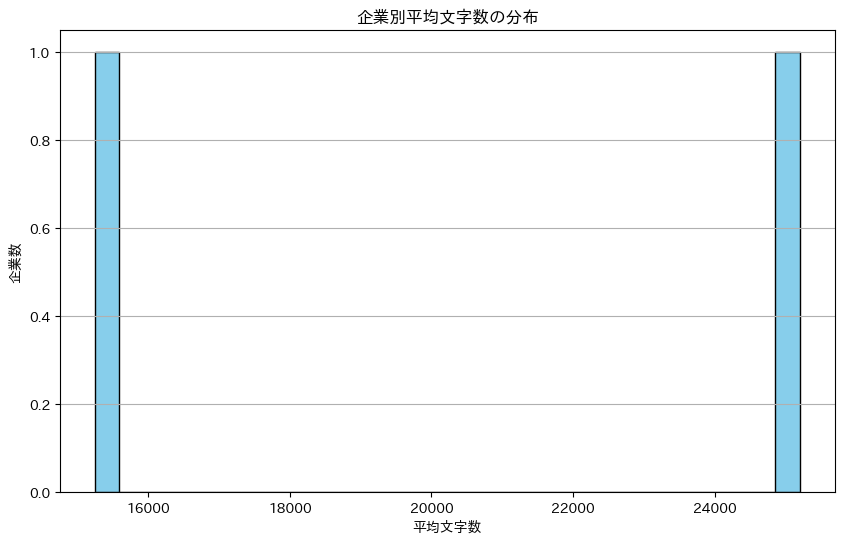

,CD,DATE,TEXT,year,char_count
0,2753,20110303,平成00年0月期決算短信〔日本基準〕（連結）平成00年0月0日（百万円未満切捨て）上場会社名...,2011,24581
1,6305,20110304,（百万円未満切捨て）0．平成00年0月期の連結業績（平成00年0月0日平成00年0月00日）...,2011,29314
2,2753,20120303,平成00年0月期第0四半期決算短信〔日本基準〕（連結）平成00年0月0日（百万円未満切捨て）...,2012,5690
3,6305,20120304,（百万円未満四捨五入）0．平成00年0月期の連結業績（平成00年0月0日平成00年0月00日...,2012,22836
4,2753,20130303,平成00年0月期決算短信〔日本基準〕（連結）平成00年0月0日（百万円未満切捨て）上場会社名...,2013,15464


In [7]:
# 文字数の分布

# 文字数を計算
combined_df['char_count'] = combined_df['TEXT'].str.len()

# 企業ごとの平均文字数を計算
average_char_count_by_company = combined_df.groupby('CD')['char_count'].mean()

# 文字数の範囲を決める
char_count_range = (average_char_count_by_company.min(), average_char_count_by_company.max())

# ヒストグラムのビンを作成
bins = np.linspace(char_count_range[0], char_count_range[1], 30)

# プロット
plt.figure(figsize=(10, 6))
plt.hist(average_char_count_by_company.values, bins=bins, color='skyblue', edgecolor='black')
plt.title('企業別平均文字数の分布')
plt.xlabel('平均文字数')
plt.ylabel('企業数')
plt.grid(axis='y')
plt.show()

combined_df.head()


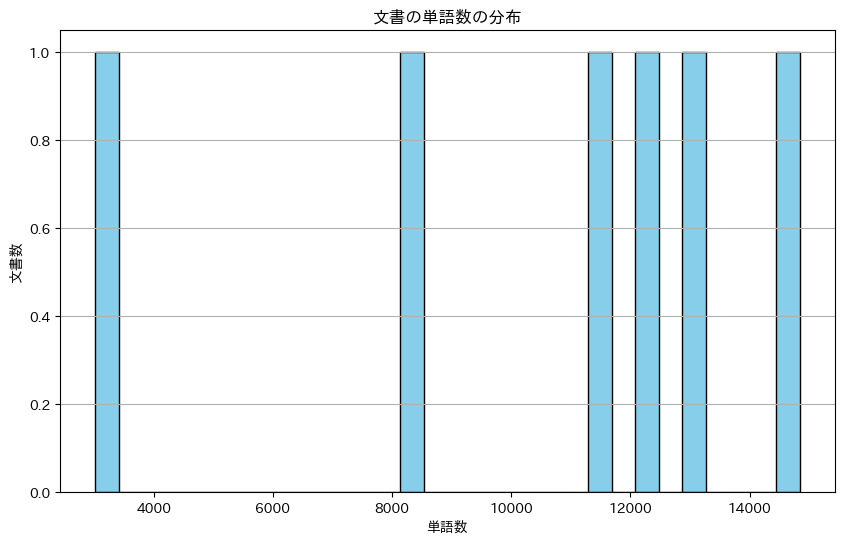

In [8]:
# mecab-ipadic-NEologdのパスを指定してMeCabを初期化
# 'mecabrc'のパスは実際の環境に合わせて適宜変更してください。
mecab = MeCab.Tagger('-d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd')

# 単語数カウント関数（上述の関数と同様）
def count_words(text):
    mecab.parse('')  # 空文字列をparseすることで、文字列が初期化されるバグを回避
    node = mecab.parseToNode(text)
    count = 0
    while node:
        if node.feature.split(',')[0] != 'BOS/EOS':
            count += 1
        node = node.next
    return count

# テキストのDataFrameに単語数カラムを追加
combined_df['word_count'] = combined_df['TEXT'].apply(count_words)

# 単語数の分布をヒストグラムで可視化
plt.figure(figsize=(10, 6))
plt.hist(combined_df['word_count'], bins=30, color='skyblue', edgecolor='black')
plt.title('文書の単語数の分布')
plt.xlabel('単語数')
plt.ylabel('文書数')
plt.grid(axis='y')
plt.show()
